In [36]:
import sys
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [37]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import imageio

In [38]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(0)
if use_cuda:
    torch.cuda.manual_seed(0)

In [39]:
BATCH_SIZE = 64
EPOCH = 100

range_ = (-1, 14)
n_grid = 2000
n_train = 1000
prob = 0.2

uncert_nets = 100
uncert_nets2 = 10

In [82]:
def sampler(num, mean1=2, std1=0.25, mean2=8, std2=1, p=0.5):
    p = (torch.rand(num) > p).float()

    mean1 = torch.from_numpy(np.array([mean1]*num)).float()
    mean2 = torch.from_numpy(np.array([mean2]*num)).float()
    std1 = torch.from_numpy(np.array([std1]*num)).float()
    std2 = torch.from_numpy(np.array([std2]*num)).float()

    samples1 = torch.normal(mean1, std1)
    samples2 = torch.normal(mean2, std2)
    
    return p*samples1 + (1-p)*samples2

def real_funcion(x):
    return x + 6*torch.sin(x) #+ 0.2*torch.rand(x.size())

# Datos generados

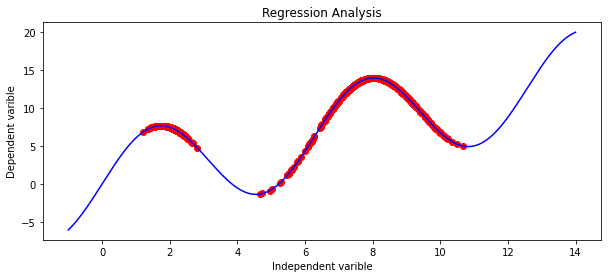

In [41]:
torch.manual_seed(1)    # reproducible

x = torch.unsqueeze(torch.linspace(range_[0], range_[1], n_grid), dim=1)  # x data (tensor), shape=(100, 1)
y = real_funcion(x)
x_train = torch.unsqueeze(sampler(n_train), dim=1)
y_train = real_funcion(x_train)

# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)
plt.figure(figsize=(10,4))
plt.plot(x.data.numpy(), y.data.numpy(), color = "blue")
plt.scatter(x_train.data.numpy(), y_train.data.numpy(), color = "red")
plt.title('Regression Analysis')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
#plt.savefig('curve_2.png')
plt.show()


# Red neuronal con Dropout

In [65]:
def train(EPOCH, net, x_train, y_train, BATCH_SIZE, lr=0.01):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

    torch_dataset = Data.TensorDataset(x_train, y_train)

    loader = Data.DataLoader(
        dataset=torch_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, num_workers=2,)

    #my_images = []
    #fig, ax = plt.subplots(figsize=(16,10))

    loss_array = []

    # start training
    for epoch in range(EPOCH):
        running_loss = 0
        for step, (batch_x, batch_y) in enumerate(loader): # for each training step
            
            b_x = Variable(batch_x).to(device)
            b_y = Variable(batch_y).to(device)

            prediction = net(b_x)     # input x and predict based on x

            loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)
            
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients

            running_loss += loss
            """
            if step == 1:
                # plot and show learning process
                plt.cla()
                ax.set_title('Regression Analysis - model 3 Batches', fontsize=35)
                ax.set_xlabel('Independent variable', fontsize=24)
                ax.set_ylabel('Dependent variable', fontsize=24)
                #ax.set_xlim(-11.0, 13.0)
                #ax.set_ylim(-1.1, 1.2)
                ax.scatter(b_x.cpu().data.numpy(), b_y.cpu().data.numpy(), color = "blue", alpha=0.2)
                ax.scatter(b_x.cpu().data.numpy(), prediction.cpu().data.numpy(), color='green', alpha=0.5)
                ax.text(8, 4, 'Epoch = %d' % (epoch+1),
                        fontdict={'size': 24, 'color':  'red'})
                ax.text(8, 2, 'Loss = %.4f' % loss.cpu().data.numpy(),
                        fontdict={'size': 24, 'color':  'red'})

                # Used to return the plot as an image array 
                # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
                fig.canvas.draw()       # draw the canvas, cache the renderer
                image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
                image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

                my_images.append(image)
            """
        loss_array.append(running_loss.cpu().data.numpy())
        print("\rEpoch: {}/{}\tLoss: {}".format(epoch+1, EPOCH, running_loss), end="")
    return np.stack(loss_array)

In [43]:
# another way to define a network
net = torch.nn.Sequential(
        torch.nn.Linear(1, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Dropout(p=prob),
        torch.nn.Linear(200, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Dropout(p=prob),
        torch.nn.Linear(100, 1),
    ).to(device)

train(EPOCH, net, x_train, y_train, BATCH_SIZE)

Epoch: 100/100	Loss: 16.175861358642578

array([369.1513  , 118.25143 ,  92.450134,  95.43106 ,  92.22729 ,
        92.71437 ,  86.40777 ,  93.17292 ,  78.56743 ,  82.982285,
        85.55376 ,  86.943794,  80.194855,  81.67621 ,  73.88754 ,
        79.34274 ,  85.105606,  73.82108 ,  73.21251 ,  72.650795,
        76.41143 ,  71.99427 ,  77.94866 ,  64.94739 ,  68.15605 ,
        63.28747 ,  66.94622 ,  59.54074 ,  57.343597,  53.234425,
        57.23597 ,  57.094406,  57.239742,  58.15299 ,  53.35443 ,
        52.061153,  47.54405 ,  46.102528,  40.57097 ,  51.325188,
        47.314857,  46.36956 ,  45.136513,  48.218903,  39.82373 ,
        43.072533,  39.83548 ,  33.6646  ,  35.931072,  37.649303,
        35.2897  ,  34.917355,  34.011448,  33.07706 ,  30.738573,
        36.555573,  45.112118,  31.596209,  29.749788,  34.365993,
        36.835583,  32.120834,  30.021053,  31.504404,  28.586765,
        29.795353,  27.343544,  31.285072,  30.194124,  27.238968,
        26.308767,  33.199986,  24.299576,  35.780304,  27.964

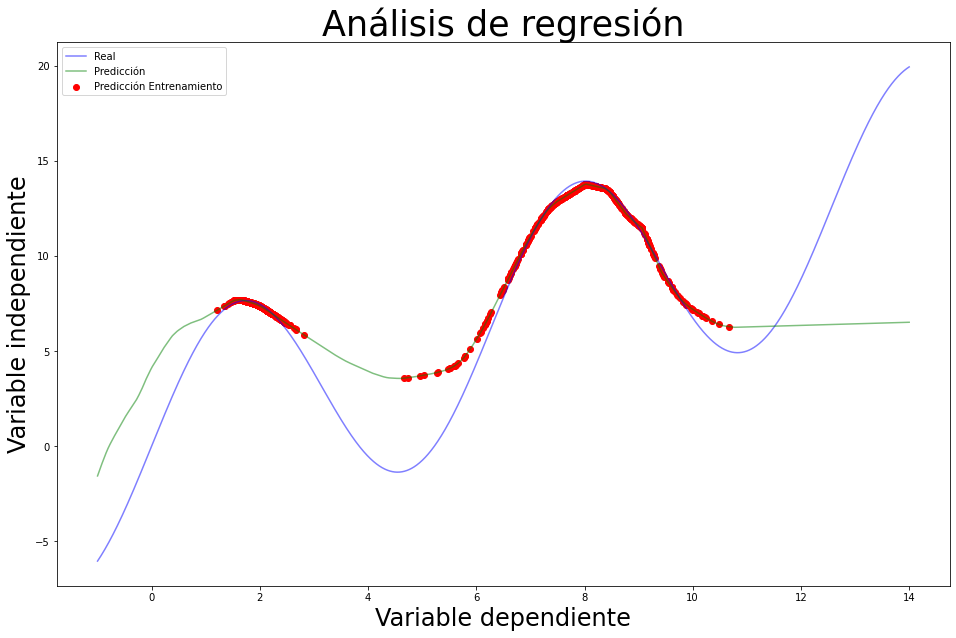

Sequential(
  (0): Linear(in_features=1, out_features=200, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=200, out_features=100, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=100, out_features=1, bias=True)
)

In [44]:
# save images as a gif    
#imageio.mimsave('./curve_2_model_3_batch.gif', my_images, fps=12)

net.eval()

fig, ax = plt.subplots(figsize=(16,10))
plt.cla()
ax.set_title('Análisis de regresión', fontsize=35)
ax.set_xlabel('Variable dependiente', fontsize=24)
ax.set_ylabel('Variable independiente', fontsize=24)
#ax.set_xlim(-11.0, 13.0)
#ax.set_ylim(-1.1, 1.2)
ax.plot(x.data.numpy(), y.data.numpy(), label="Real", color = "blue", alpha=0.5)
with torch.no_grad():
    prediction = net(x.to(device))     # input x and predict based on x
ax.plot(x.data.numpy(), prediction.cpu().data.numpy(), label="Predicción", color='green', alpha=0.5)
with torch.no_grad():
    prediction = net(x_train.to(device))     # input x and predict based on x
ax.scatter(x_train.data.numpy(), prediction.cpu().data.numpy(), label="Predicción Entrenamiento", color='red', alpha=1)
#plt.savefig('curve_2_model_3_batches.png')
plt.legend()
plt.show()

net.train()

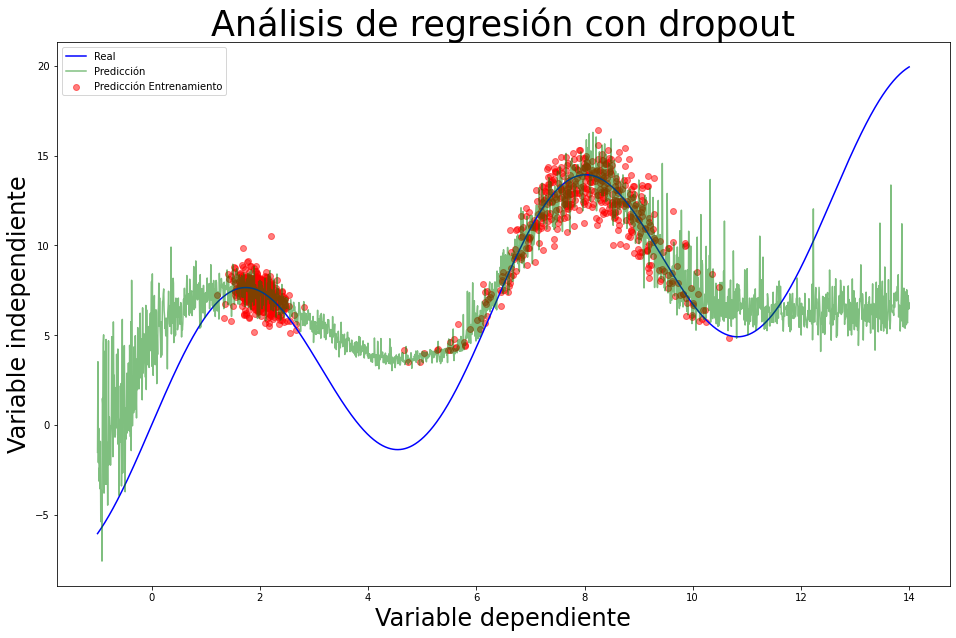

In [45]:
fig, ax = plt.subplots(figsize=(16,10))
plt.cla()
ax.set_title('Análisis de regresión con dropout', fontsize=35)
ax.set_xlabel('Variable dependiente', fontsize=24)
ax.set_ylabel('Variable independiente', fontsize=24)
#ax.set_xlim(-11.0, 13.0)
#ax.set_ylim(-1.1, 1.2)
ax.plot(x.data.numpy(), y.data.numpy(), label="Real", color = "blue", alpha=1)
with torch.no_grad():
    prediction = net(x.to(device))     # input x and predict based on x
ax.plot(x.data.numpy(), prediction.cpu().data.numpy(), label="Predicción", color='green', alpha=0.5)
with torch.no_grad():
    prediction = net(x_train.to(device))     # input x and predict based on x
ax.scatter(x_train.data.numpy(), prediction.cpu().data.numpy(), label="Predicción Entrenamiento", color='red', alpha=0.5)
#plt.savefig('curve_2_model_3_batches.png')
plt.legend()
plt.show()

In [46]:
def get_uncert(net, q, x, x_train):
    net.train()
    predictions = []
    train_preds = []
    for _ in range(q):
        with torch.no_grad():
            predictions.append(net(x.to(device)))
            train_preds.append(net(x_train.to(device)))
    predictions_train = torch.stack(train_preds).squeeze()
    predictions = torch.stack(predictions).squeeze()

    mean_pred = torch.mean(predictions, dim=0)
    uncertainties = torch.std(predictions, dim=0)

    mean_pred_train = torch.mean(predictions_train, dim=0)
    uncertainties_train = torch.std(predictions_train, dim=0)

    return (mean_pred, uncertainties), (mean_pred_train, uncertainties_train)

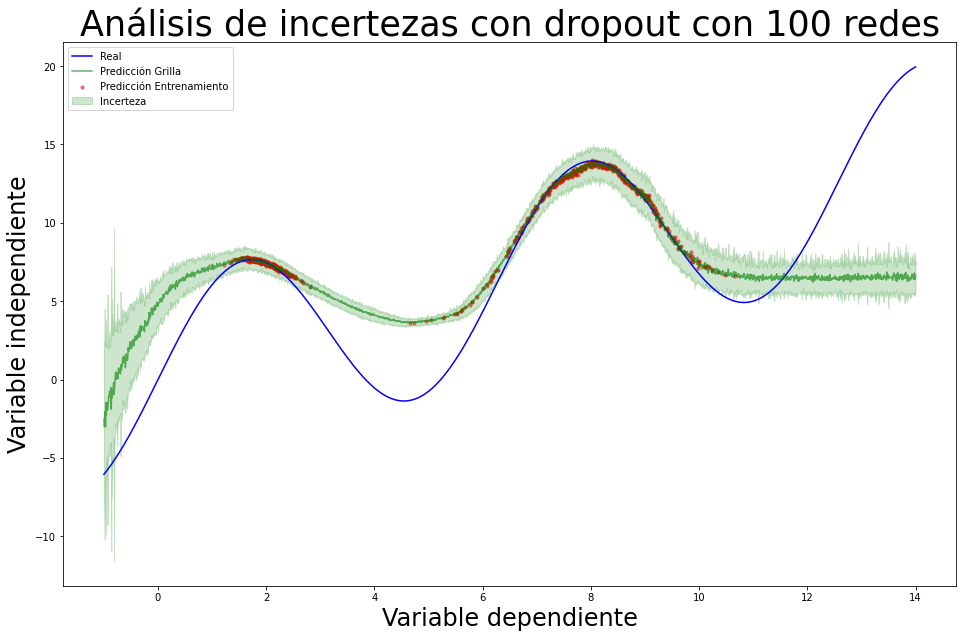

In [47]:
(mean_pred, uncertainties), (mean_pred_train, uncertainties_train) = get_uncert(net, uncert_nets, x, x_train)

fig, ax = plt.subplots(figsize=(16,10))
plt.cla()
ax.set_title('Análisis de incertezas con dropout con {} redes'.format(uncert_nets), fontsize=35)
ax.set_xlabel('Variable dependiente', fontsize=24)
ax.set_ylabel('Variable independiente', fontsize=24)
#ax.set_xlim(-11.0, 13.0)
#ax.set_ylim(-1.1, 1.2)
ax.plot(x.data.numpy(), y.data.numpy(), label="Real", color = "blue", alpha=1)
ax.plot(x.data.numpy(), mean_pred.cpu().data.numpy(), label="Predicción Grilla", color = "green", alpha=0.6)
#ax.scatter(x_train.data.numpy(), y_train.data.numpy(), label="Entrenamiento Real", color = "red", alpha=0.5)
ax.scatter(x_train.data.numpy(), mean_pred_train.cpu().data.numpy(), label="Predicción Entrenamiento", color = "red", alpha=0.5, s=10)
ax.fill_between(x.squeeze().data.numpy(), (mean_pred - uncertainties).cpu().data.numpy(), (mean_pred + uncertainties).cpu().data.numpy(), color="green", alpha=0.2, label="Incerteza")
#with torch.no_grad():
#    prediction = net(x.to(device))     # input x and predict based on x
#ax.plot(x.data.numpy(), prediction.cpu().data.numpy(), label="Predicción", color='green', alpha=0.5)
#with torch.no_grad():
#    prediction = net(x_train.to(device))     # input x and predict based on x
#ax.scatter(x_train.data.numpy(), prediction.cpu().data.numpy(), label="Predicción Entrenamiento", color='red', alpha=1)
#plt.savefig('curve_2_model_3_batches.png')
plt.legend()
plt.show()

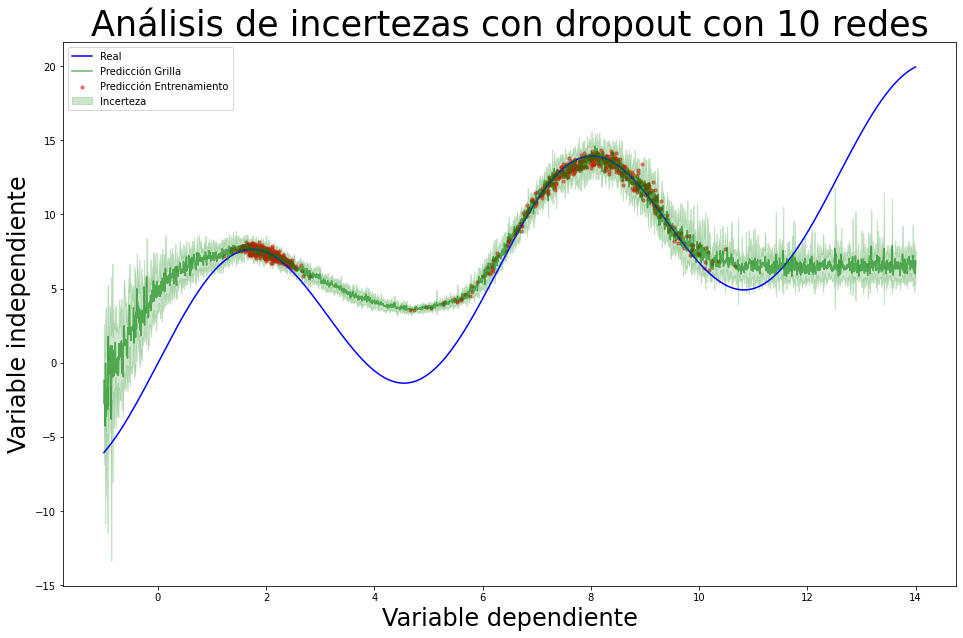

In [48]:
(mean_pred, uncertainties), (mean_pred_train, uncertainties_train) = get_uncert(net, uncert_nets2, x, x_train)

fig, ax = plt.subplots(figsize=(16,10))
plt.cla()
ax.set_title('Análisis de incertezas con dropout con {} redes'.format(uncert_nets2), fontsize=35)
ax.set_xlabel('Variable dependiente', fontsize=24)
ax.set_ylabel('Variable independiente', fontsize=24)
#ax.set_xlim(-11.0, 13.0)
#ax.set_ylim(-1.1, 1.2)
ax.plot(x.data.numpy(), y.data.numpy(), label="Real", color = "blue", alpha=1)
ax.plot(x.data.numpy(), mean_pred.cpu().data.numpy(), label="Predicción Grilla", color = "green", alpha=0.6)
#ax.scatter(x_train.data.numpy(), y_train.data.numpy(), label="Entrenamiento Real", color = "red", alpha=0.5)
ax.scatter(x_train.data.numpy(), mean_pred_train.cpu().data.numpy(), label="Predicción Entrenamiento", color = "red", alpha=0.5, s=10)
ax.fill_between(x.squeeze().data.numpy(), (mean_pred - uncertainties).cpu().data.numpy(), (mean_pred + uncertainties).cpu().data.numpy(), color="green", alpha=0.2, label="Incerteza")
#with torch.no_grad():
#    prediction = net(x.to(device))     # input x and predict based on x
#ax.plot(x.data.numpy(), prediction.cpu().data.numpy(), label="Predicción", color='green', alpha=0.5)
#with torch.no_grad():
#    prediction = net(x_train.to(device))     # input x and predict based on x
#ax.scatter(x_train.data.numpy(), prediction.cpu().data.numpy(), label="Predicción Entrenamiento", color='red', alpha=1)
#plt.savefig('curve_2_model_3_batches.png')
plt.legend()
plt.show()

# Procesos gaussianos

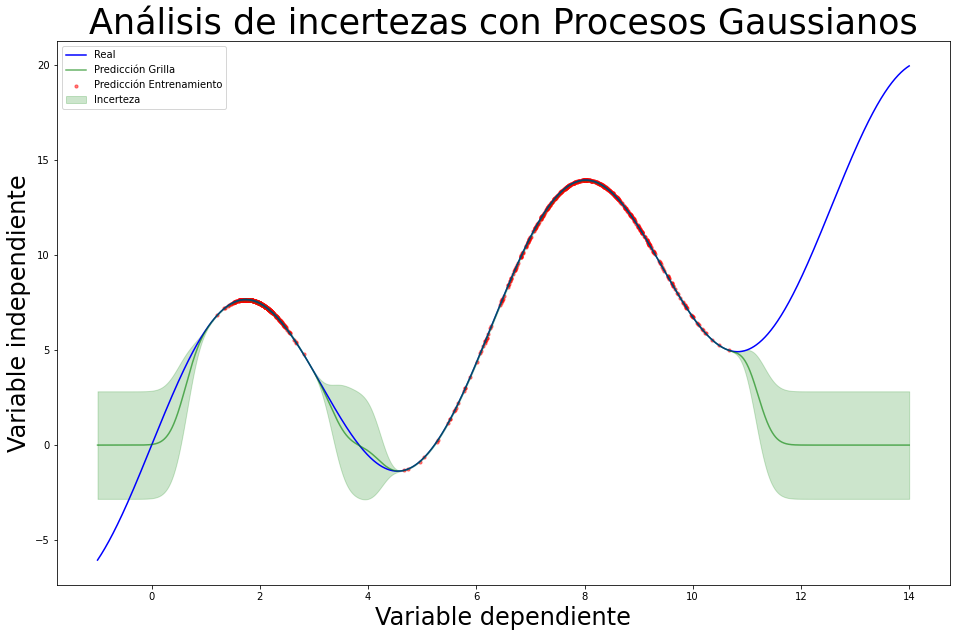

In [49]:
kernel = ConstantKernel(8.0, constant_value_bounds="fixed") * RBF(0.3, length_scale_bounds="fixed")

gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(x_train.cpu().data.numpy(), y_train.cpu().data.numpy())
(gpr_mean_train, gpr_std_train) = gpr.predict(x_train.cpu().data.numpy(), return_std=True)
(gpr_mean, gpr_std) = gpr.predict(x.cpu().data.numpy(), return_std=True)

fig, ax = plt.subplots(figsize=(16,10))
plt.cla()
ax.set_title('Análisis de incertezas con Procesos Gaussianos', fontsize=35)
ax.set_xlabel('Variable dependiente', fontsize=24)
ax.set_ylabel('Variable independiente', fontsize=24)
#ax.set_xlim(-11.0, 13.0)
#ax.set_ylim(-1.1, 1.2)
ax.plot(x.data.numpy(), y.data.numpy(), label="Real", color = "blue", alpha=1)
ax.plot(x.data.numpy(), gpr_mean.squeeze(), label="Predicción Grilla", color = "green", alpha=0.6)
#ax.scatter(x_train.data.numpy(), y_train.data.numpy(), label="Entrenamiento Real", color = "red", alpha=0.5)
ax.scatter(x_train.data.numpy(), gpr_mean_train.squeeze(), label="Predicción Entrenamiento", color = "red", alpha=0.5, s=10)
ax.fill_between(x.squeeze().data.numpy(), (gpr_mean.squeeze() - gpr_std), (gpr_mean.squeeze() + gpr_std), color="green", alpha=0.2, label="Incerteza")
#with torch.no_grad():
#    prediction = net(x.to(device))     # input x and predict based on x
#ax.plot(x.data.numpy(), prediction.cpu().data.numpy(), label="Predicción", color='green', alpha=0.5)
#with torch.no_grad():
#    prediction = net(x_train.to(device))     # input x and predict based on x
#ax.scatter(x_train.data.numpy(), prediction.cpu().data.numpy(), label="Predicción Entrenamiento", color='red', alpha=1)
#plt.savefig('curve_2_model_3_batches.png')
plt.legend()
plt.show()

# Análisis de incertezas de dropout en el tiempo

In [83]:
def uncert_intime(iterations, net, epochs, n, batch_size, uncert_nets, grid, gridy, lr=0.01):
    fig, ax = plt.subplots(figsize=(16,10))
    my_images = []

    x = []
    y = []

    for i in range(iterations):
        print("Iteracion {}/{}".format(i+1, iterations))
        x_train = torch.unsqueeze(sampler(n, p=0.7), dim=1)
        y_train = real_funcion(x_train)

        if i == 0:
            x = x_train
            y = y_train
        else:
            x = torch.cat((x, x_train), dim=0)
            y = torch.cat((y, y_train), dim=0)
        
        loss = train(epochs, net, x_train, y_train, batch_size, lr=lr)
        #loss = train(epochs, net, x, y, batch_size, lr=lr)
        (mean_pred, uncertainties), (mean_pred_train, uncertainties_train) = get_uncert(net, uncert_nets, grid, x)
        
        
        plt.cla()
        ax.set_title('Análisis de incertezas con dropout con {} redes'.format(uncert_nets), fontsize=35)
        ax.set_xlabel('Variable dependiente', fontsize=24)
        ax.set_ylabel('Variable independiente', fontsize=24)
        ax.set_xlim(-1, 14)
        ax.set_ylim(-5, 20)
        ax.plot(grid.data.numpy(), gridy.data.numpy(), label="Real", color = "blue", alpha=1)
        ax.plot(grid.data.numpy(), mean_pred.cpu().data.numpy(), label="Predicción Grilla", color = "green", alpha=0.6)
        #ax.scatter(x_train.data.numpy(), y_train.data.numpy(), label="Entrenamiento Real", color = "red", alpha=0.5)
        ax.scatter(x.cpu().data.numpy(), mean_pred_train.cpu().data.numpy(), label="Predicción Entrenamiento", color = "red", alpha=0.5, s=10)
        ax.fill_between(grid.squeeze().data.numpy(), (mean_pred - uncertainties).cpu().data.numpy(), (mean_pred + uncertainties).cpu().data.numpy(), color="green", alpha=0.2, label="Incerteza")
        ax.legend()
        
        ax.text(10, -5, 'Iteracion = %d' % (i+1),
                        fontdict={'size': 24, 'color':  'red'})
        ax.text(10, -8, 'Loss = %.4f' % (np.sum(loss)/epochs),
                fontdict={'size': 24, 'color':  'red'})

        # Used to return the plot as an image array 
        # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        my_images.append(image)
        
        print("")

    imageio.mimsave('./curve.gif', my_images, fps=10)


In [88]:
n = 150
batch_size = 200
epochs = 4
iterations = 100
net = torch.nn.Sequential(
        torch.nn.Linear(1, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Dropout(p=prob),
        torch.nn.Linear(200, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Dropout(p=prob),
        torch.nn.Linear(100, 1),
    ).to(device)
uncert_nets = 100

lr = 1e-3

Iteracion 1/100
Epoch: 4/4	Loss: 54.08675765991211
Iteracion 2/100
Epoch: 4/4	Loss: 21.59123420715332
Iteracion 3/100
Epoch: 4/4	Loss: 10.422008514404297
Iteracion 4/100
Epoch: 4/4	Loss: 11.62451171875
Iteracion 5/100
Epoch: 4/4	Loss: 11.790094375610352
Iteracion 6/100
Epoch: 4/4	Loss: 10.761785507202148
Iteracion 7/100
Epoch: 4/4	Loss: 11.33471393585205
Iteracion 8/100
Epoch: 4/4	Loss: 7.515133857727051
Iteracion 9/100
Epoch: 4/4	Loss: 6.170832633972168
Iteracion 10/100
Epoch: 4/4	Loss: 7.335277557373047
Iteracion 11/100
Epoch: 4/4	Loss: 8.446569442749023
Iteracion 12/100
Epoch: 4/4	Loss: 7.240511417388916
Iteracion 13/100
Epoch: 4/4	Loss: 7.555078506469727
Iteracion 14/100
Epoch: 4/4	Loss: 6.591494083404541
Iteracion 15/100
Epoch: 4/4	Loss: 6.711633682250977
Iteracion 16/100
Epoch: 4/4	Loss: 5.994976997375488
Iteracion 17/100
Epoch: 4/4	Loss: 6.5075507164001465
Iteracion 18/100
Epoch: 4/4	Loss: 7.066736698150635
Iteracion 19/100
Epoch: 4/4	Loss: 7.520631790161133
Iteracion 20/100
Epo

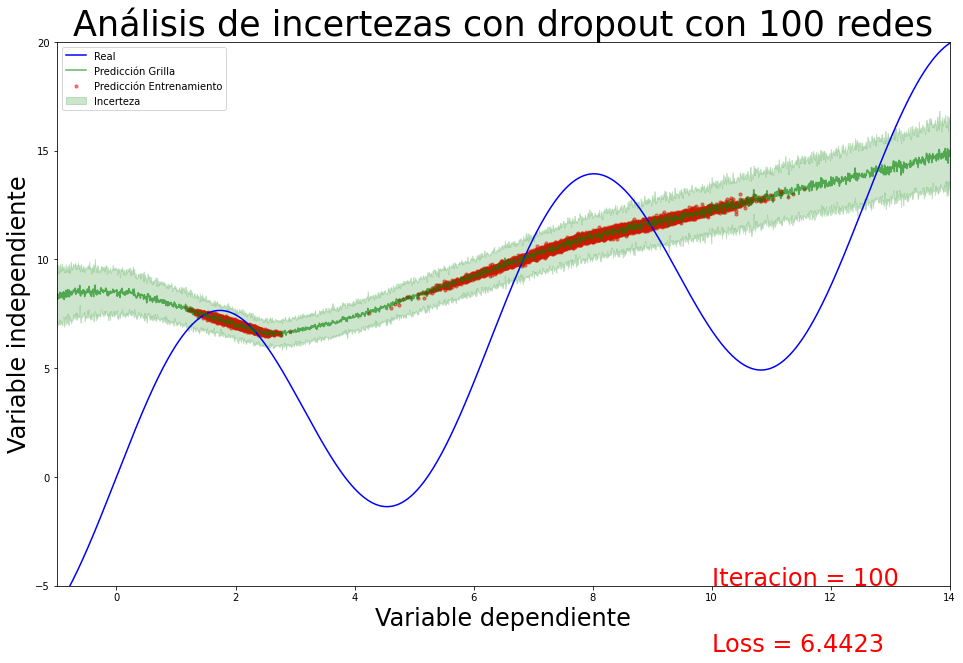

In [89]:
uncert_intime(iterations, net, epochs, n, batch_size, uncert_nets, x, y, lr=lr)